In [34]:
import os
import sys
import numpy as np
from keras.models import model_from_json
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg16
import tensorflow
import pandas as pd
from tqdm import tqdm, tqdm_notebook
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import sklearn
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model

In [35]:
class config:
    img_size = 128
    thres = 0.5
    nms_thress = 0.2
    root = 'D:/01.Document/Cao hoc/DL-ML/project/petfinder-adoption-prediction/'

In [61]:
train_df = pd.read_csv(config.root + 'train/train.csv')
pet_ids = train_df['PetID'].values
img_size = 128
nb_classes = 5
batch_size  = 32

In [81]:
classNames = []
classFile = config.root + 'coco_dectection/coco.names'
with open(classFile,'rt') as f:
    classNames = f.read().rstrip('\n').split('\n')
print(classNames)
    
configPath = config.root + 'coco_dectection/ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt'
weightsPath = config.root + 'coco_dectection/frozen_inference_graph.pb'

net = cv.dnn_DetectionModel(weightsPath,configPath)
net.setInputSize(320,320)
net.setInputScale(1.0/127.5)
net.setInputMean((127.5,127.5,127.5))
net.setInputSwapRB(True)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush']


<dnn_Model 0000013D88C15CB0>

In [82]:
def objdetect(imgPath):
    img = cv.imread(imgPath)
    classIds, confs, bbox = net.detect(img,confThreshold=config.thres)
    if len(classIds) != 0:
        for classId, confidence,box in zip(classIds.flatten(),confs.flatten(),bbox):
            if classId == 17 or classId == 18:
                if confidence == confs.max():
                    roi = img[box[1]:box[1] + box[3], box[0]:box[0] + box[2]]
            else:
                roi = img
    return roi

In [83]:
def resize_to_square(imgPath):
    
    im = objdetect(imgPath)
    
    old_size = im.shape[:2]
    ratio = float(config.img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])    
    im = cv.resize(im, (new_size[1], new_size[0]))
    delta_w = config.img_size - new_size[1]
    delta_h = config.img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv.copyMakeBorder(im, top, bottom, left, right, cv.BORDER_CONSTANT,value=color)
    return new_im
def load_image(imgPath):
    new_image = resize_to_square(imgPath)
    return new_image

In [84]:
pet_ids = train_df['PetID'].values

In [85]:
%%time
X = []
Y = []
petid = []
for pet_id in tqdm(pet_ids[0:100]):
    try:
        im = load_image(config.root + "train_images/"+ pet_id + '-1.jpg')
        X.append(im)        
        ads = train_df[train_df['PetID'] == pet_id]['AdoptionSpeed'].values[0]
        ids = train_df[train_df['PetID'] == pet_id]['PetID'].values[0]
        Y.append(ads)
        petid.append(ids)
    except:
        pass  
X = np.asarray(X)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.96it/s]

Wall time: 6.27 s


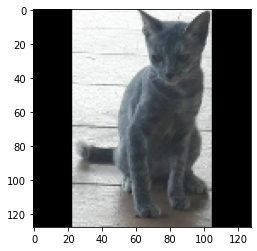

In [125]:
plt.imshow(cv.cvtColor(X[5], cv.COLOR_BGR2RGB))

In [39]:
np.save('x.npy',X)
np.save('y.npy',Y)
np.save('id.npy',petid)

In [40]:
from sklearn.model_selection import train_test_split
X_tr, X_tst, y_tr, y_tst = train_test_split(X, Y, test_size=0.33, random_state=42)

In [41]:
X_tr = X_tr.astype('float32')
X_tst = X_tst.astype('float32')
X_tr /= 255
X_tst /= 255

In [42]:
Y_tr = to_categorical(y_tr, nb_classes)
Y_tst = to_categorical(y_tst, nb_classes)

In [43]:
# Getting model:
model_file = open(root + 'Model/Resnet50_model.json', 'r')
model = model_file.read()
model_file.close()
model = model_from_json(model)
model.load_weights(root + "Model/Resnet50_weights.h5")

In [44]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [53]:
tensorflow.random.Generator = None
import tensorflow_addons as tfa

In [156]:
input_layer = model.get_layer('dense_21')

In [163]:
def layer_added(output_based_network, num_classes):
    x = output_based_network
    x = Dense(128, activation='relu')(x)
    x = Dense(nb_classes, activation='softmax')(x)

    return x

In [164]:
output_layer = layer_added(input_layer.output, 5)

In [165]:
new_model = Model(model.input, output_layer)
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [166]:
for layer in new_model.layers[:-2]:
    layer.trainable = False 

In [167]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [55]:
#opt = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
new_model.compile(loss = tfa.losses.kappa_loss.WeightedKappaLoss(num_classes = nb_classes),
              optimizer=opt,
              metrics=['accuracy'])

C:\Users\pqhie\.conda\envs\tensorflow\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [169]:
%%time
# Train model
history = new_model.fit(X_tr, Y_tr,
              batch_size=batch_size,
              epochs=nb_epoch,
              validation_split=0.1,
              shuffle=True,
              verbose=2)

Epoch 1/50
277/277 - 276s - loss: 0.1520 - accuracy: 0.2960 - val_loss: 0.1504 - val_accuracy: 0.3350
Epoch 2/50
277/277 - 258s - loss: 0.1504 - accuracy: 0.3197 - val_loss: 0.1494 - val_accuracy: 0.3483
Epoch 3/50
277/277 - 266s - loss: 0.1497 - accuracy: 0.3304 - val_loss: 0.1518 - val_accuracy: 0.3330
Epoch 4/50
277/277 - 243s - loss: 0.1495 - accuracy: 0.3237 - val_loss: 0.1498 - val_accuracy: 0.3350
Epoch 5/50
277/277 - 235s - loss: 0.1494 - accuracy: 0.3285 - val_loss: 0.1511 - val_accuracy: 0.3350
Epoch 6/50
277/277 - 233s - loss: 0.1492 - accuracy: 0.3344 - val_loss: 0.1492 - val_accuracy: 0.3585
Epoch 7/50
277/277 - 233s - loss: 0.1490 - accuracy: 0.3331 - val_loss: 0.1491 - val_accuracy: 0.3564
Epoch 8/50
277/277 - 234s - loss: 0.1488 - accuracy: 0.3363 - val_loss: 0.1486 - val_accuracy: 0.3523
Epoch 9/50
277/277 - 237s - loss: 0.1487 - accuracy: 0.3365 - val_loss: 0.1486 - val_accuracy: 0.3462
Epoch 10/50
277/277 - 232s - loss: 0.1485 - accuracy: 0.3380 - val_loss: 0.1500 - 

In [182]:
scores = new_model.evaluate(X_tst, Y_tst, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 31.49%


In [184]:
Y_pre = new_model.predict(X_tst)

In [185]:
y_pred=np.argmax(Y_pre, axis=1)
y_test=np.argmax(Y_tst, axis=1)

In [186]:
cohen_kappa = sklearn.metrics.cohen_kappa_score(y_pred,y_test)

In [187]:
cohen_kappa

0.08020754144404785

In [171]:
def save_model(root, model):
    if not os.path.exists(root + 'Model/'):
        os.makedirs(root + 'Model/')
    model_json = model.to_json()
    with open(root + "Model/Resnet50_model.json", "w") as model_file:
        model_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(root + "/Model/Resnet50_weights.h5")
    print('Model and weights saved')
    return

In [181]:
save_model(root, new_model)

C:\Users\pqhie\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Model and weights saved
